In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib
import matplotlib.pyplot as plt 
import cv2
from tqdm import tqdm
from PIL import Image, ImageMath
%matplotlib inline

In [2]:
root = "/datasets/mammography/"
DDSM_dir = os.path.join(root, "CBIS-DDSM")

mass_train = pd.read_csv('/datasets/mammography/new_mass_case_description_train_set.csv')
cal_train = pd.read_csv('/datasets/mammography/new_calc_case_description_train_set.csv')

mass_test = pd.read_csv('/datasets/mammography/new_mass_case_description_test_set.csv')
cal_test = pd.read_csv('/datasets/mammography/new_calc_case_description_test_set.csv')

patches_dir = os.path.join(root, "patches_data")

In [25]:
mass_train.head()

,Unnamed: 0,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...
1,1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...
2,2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...
3,3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...
4,4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...,/datasets/mammography/CBIS-DDSM/Mass-Training_...


TypeError: Image data of dtype object cannot be converted to float

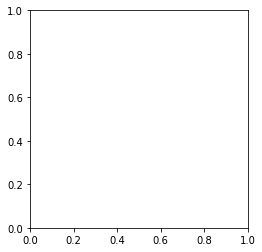

In [38]:
mask = cv2.imread(mass_train.iloc[1]['image file path'][:-1].replace(".dcm", ".png").strip())
plt.imshow(mask)

In [5]:
errors = 0
for root, subFolder, file_names in os.walk(DDSM_dir):
    for file_name in tqdm(file_names):
        dicom_path = os.path.join(root, file_name)
        out_path = os.path.join(root, file_name)
        out_path = out_path.split(".dcm")[0] + ".png"
        image = pydicom.dcmread(dicom_path).pixel_array
        image = cv2.resize(image, (1152, 832), interpolation = cv2.INTER_AREA)
        status = cv2.imwrite(out_path,  cv2.normalize(image, None, alpha = 0, 
                                      beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F))
        if not status:
            errors += 1
print("Number of Errors: ", errors)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/4 [00:00<?, ?it/s]


InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.

In [12]:
mass_train['pathology'].unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [14]:
def count_black_and_white(img):
    return np.sum(img == 255), np.sum(img == 0)

In [15]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield x, y, image[y:y + windowSize[1], x:x + windowSize[0]]

In [5]:
df = mass_train.append(mass_test, ignore_index=True)
print(len(df))
root_dir = "/datasets/mammography/"
dir_name = "patches_data"
patches_path = os.path.join(root_dir, dir_name)
part_name = df.iloc[0]['abnormality type']
part_dir = os.path.join(patches_path, "normal")
if not os.path.exists(part_dir):
    os.mkdir(part_dir)
winW, winH = 224, 224
counter = 0
if not os.path.exists(patches_path):
    os.mkdir(patches_path)
for index, row in tqdm(df.iterrows(), total=len(df)):
    mask_png_path = row["ROI mask file path"].split(".dcm")[0] + ".png"
    crop_png_path = row["cropped image file path"].split(".dcm")[0] + ".png"
    original_image = row["image file path"].split(".dcm")[0] + ".png"
    
    original_image = cv2.imread(original_image, cv2.CV_8UC1)
    mask_image = cv2.imread(mask_png_path.strip())
    crop_image = cv2.imread(crop_png_path.strip())
    
    orig_thresh = cv2.adaptiveThreshold(original_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    
    
    mask_w, mask_b, = count_black_and_white(mask_image)
    crop_w, crop_b, = count_black_and_white(crop_image)
    
    if crop_b > 10000:
        counter += 1
        mask_image = crop_image
        mask_w, mask_b = crop_w, crop_b
    counter = 0
    for (x, y, window) in sliding_window(orig_thresh, stepSize=112, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        orig_w, orig_b = count_black_and_white(window)
        mask_w, mask_b = count_black_and_white(mask_image[y: y + winH, x: x + winW])
        if mask_w == 0 and orig_b > 150:
            primitive_path = os.path.join(part_dir, row['patient_id'] + "_" + "normal" + "_" + row['image view'] + "_" + row['left or right breast'] + "_" + str(counter) + ".png")
            cv2.imwrite(primitive_path, original_image[y: y + winH, x: x + winW])
            counter += 1

        if counter == 10:
            break

/home/yeliseev/mammography/SourceCode/vMam/local/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
  0%|          | 3/1696 [00:00<01:04, 26.30it/s]

1696


100%|██████████| 1696/1696 [01:02<00:00, 27.04it/s]


In [6]:
print(counter, "/" , len(df))

(10, '/', 1696)


In [10]:
class_dirs = os.listdir(patches_path)

In [11]:
list(enumerate(class_dirs))

[(0, 'normal'), (1, 'calcification'), (2, 'mass')]

In [12]:
image_df = {"IMG_PATH": list(), "Label": list()}
for directory in enumerate(class_dirs):
    label, lession_type = directory
    class_images_p = os.path.join(patches_path, lession_type)
    for image in os.listdir(class_images_p):
        image = os.path.join(lession_type, image)
        image_df["IMG_PATH"].append(image)
        image_df["Label"].append(label)
pd.DataFrame(image_df).to_csv("/datasets/mammography/patches_data/DDSM_Patches.csv")

In [17]:
df = cal_train.append(cal_test, ignore_index=True)
root_dir = "/datasets/mammography/"
dir_name = "patches_data_5_v1"
patches_path = os.path.join(root_dir, dir_name)
if not os.path.exists(patches_path):
    os.mkdir(patches_path)
ben_part = os.path.join(patches_path, df.iloc[0]['abnormality type'] + "_benign")
mal_part = os.path.join(patches_path, df.iloc[0]['abnormality type'] + "_malign")
if not os.path.exists(ben_part) and not os.path.exists(mal_part):
    os.mkdir(ben_part)
    os.mkdir(mal_part)
for index, row in tqdm(df.iterrows(), total=len(df)):
    mask_png_path = row["ROI mask file path"].split(".dcm")[0] + ".png"
    crop_png_path = row["cropped image file path"].split(".dcm")[0] + ".png"
    original_image = row["image file path"].split(".dcm")[0] + ".png"
    
    original_image = cv2.imread(original_image, cv2.CV_8UC1)
    mask_image = cv2.imread(mask_png_path.strip())
    crop_image = cv2.imread(crop_png_path.strip())
    
    orig_thresh = cv2.adaptiveThreshold(original_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    
    
    mask_w, mask_b, = count_black_and_white(mask_image)
    crop_w, crop_b, = count_black_and_white(crop_image)
    
    
    if crop_b > 10000:
        mask_image = crop_image
        mask_w, mask_b = crop_w, crop_b 
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    M = cv2.moments(mask_image)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    center = np.array([int(cX), int(cY)])
    adj_mask_H = 224
    adj_mask_W = 224
    
    start_col = int(np.max([center[0] - (adj_mask_W // 2), 0]))
    end_col = start_col + adj_mask_W
    
    start_row = int(np.max([center[1] - (adj_mask_H // 2), 0]))
    end_row = start_row + adj_mask_H
    
    if "MAL" in row['pathology']:
        primitive_path = os.path.join(mal_part, row['patient_id'] + "_" + "malignant" + "_" + row['image view'] + "_" + row['left or right breast'] + ".png")
    else:
        primitive_path = os.path.join(ben_part, row['patient_id'] + "_" + "bening" + "_" + row['image view'] + "_" + row['left or right breast'] + ".png")
        
    final_image = original_image[start_row:end_row, start_col:end_col]
    final_image = cv2.resize(final_image, (224, 224),interpolation=cv2.INTER_AREA)
    cv2.imwrite(primitive_path, final_image)

100%|██████████| 1872/1872 [00:54<00:00, 34.43it/s]


In [33]:
for image in os.listdir(part_dir):
    image = cv2.imread(os.path.join(part_dir, image))
    print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 